In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools
import math_functions as mf

from scipy.optimize import root
from scipy.integrate import odeint

In [29]:
###### constants ######

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 5
PC_tot = 5

C:\Users\Orlando\AppData\Local\Temp\ipykernel_2356\2463711964.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


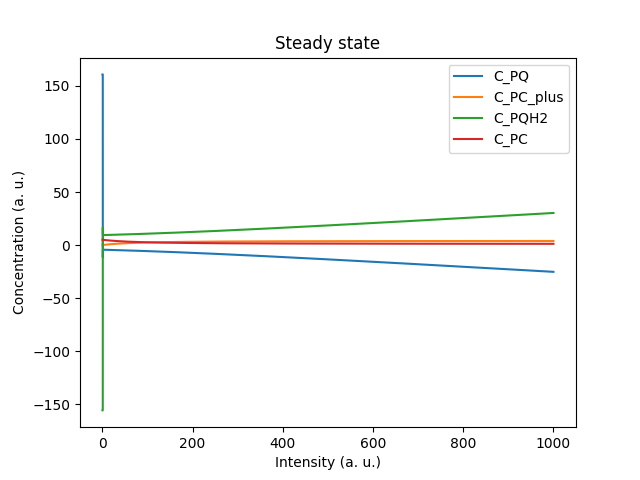

In [34]:
##### steady state #####

def steady_state(I, x0):
    def equations(x):
        
        C_PQ = x[0]
        C_PC_plus = x[1]
        
        C_PQH2 = PQ_tot - C_PQ
        C_PC = PC_tot - C_PC_plus
        
        dC_PQ_dt =  k_b6f * C_PC_plus * C_PQH2 - (I * sigma_PSII * k_p * C_PQ)/(k_p * C_PQ + k_fh)
        dPC_plus_dt = k_PSI * I * sigma_PSI * C_PC - k_b6f * C_PC_plus * C_PQH2
        
        return [dC_PQ_dt, dPC_plus_dt]
    
    sol = root(equations, x0)
    return sol.x

I = np.linspace(0.5, 1000, 10000)
C_PQ = np.zeros(len(I))
C_PC_plus = np.zeros(len(I))
C_PQH2 = np.zeros(len(I))
C_PC = np.zeros(len(I))
for i, intensity in enumerate(I):
    if i == 0:
        x0 = [7, 0]
    else:
        x0 = [C_PQ[i-1], C_PC_plus[i-1]]
    aux = steady_state(intensity, x0)
    C_PQ[i] = aux[0]
    C_PC_plus[i] = aux[1]

C_PQH2 = PQ_tot - C_PQ
C_PC = PC_tot - C_PC_plus

fig, ax = plt.subplots()
ax.plot(I, C_PQ, label='C_PQ')
ax.plot(I, C_PC_plus, label='C_PC_plus')
ax.plot(I, C_PQH2, label='C_PQH2')
ax.plot(I, C_PC, label='C_PC')
ax.set_xlabel('Intensity (a. u.)')
ax.set_ylabel('Concentration (a. u.)')
ax.set_title('Steady state')


ax.legend()


Text(0.5, 0, 'Time')

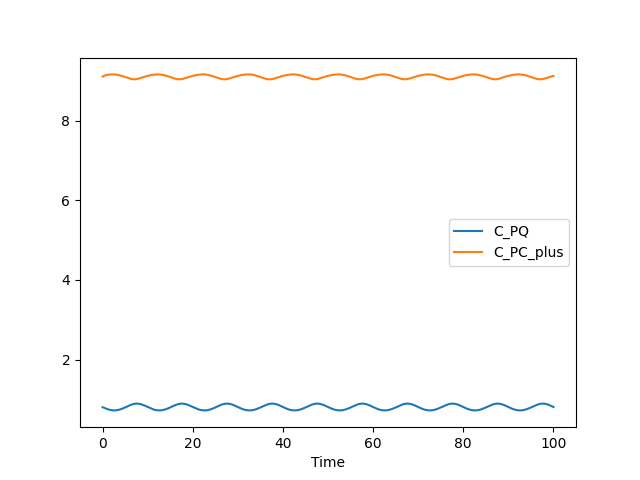

In [28]:
######## dynamic ########

def dynamic(x, t, offset, amplitude, frequency):
    
    I = offset + amplitude * np.sin(2 * np.pi * frequency * t)
    
    C_PQ = x[0]
    C_PC_plus = x[1]
    
    C_PQH2 = PQ_tot - C_PQ
    C_PC = PC_tot - C_PC_plus
    
    dC_PQ_dt =  k_b6f * C_PC_plus * C_PQH2 - (I * sigma_PSII * k_p * C_PQ)/(k_p * C_PQ + k_fh)
    dPC_plus_dt = k_PSI * I * sigma_PSI * C_PC - 2 * k_b6f * C_PC_plus * C_PQH2
    
    return [dC_PQ_dt, dPC_plus_dt]




offset = 4
amplitude = 2
frequency = 0.1

x0 = steady_state(offset, [0.1, 0.1])

t = np.linspace(0, 100, 10000)


x = odeint(dynamic, x0, t, args=(offset, amplitude, frequency))

fig, ax = plt.subplots()
ax.plot(t, x[:, 0], label='C_PQ')
ax.plot(t, x[:, 1], label='C_PC_plus')
ax.legend()
ax.set_xlabel('Time')




In [29]:
offset = 2
amplitude = 1

frenquencies = np.logspace(-3, 3, 30)
nb_periods = 50
points_per_period = 100

x0 = steady_state(offset, [0.1, 0.1])

bode_times = []
bode_PQ = []
bode_PC = []

for frequency in frenquencies:
    t = np.linspace(0, nb_periods * 1/frequency, nb_periods * points_per_period)
    x = odeint(dynamic, x0, t, args=(offset, amplitude, frequency))
    bode_times.append(t)
    bode_PQ.append(x[:, 0])
    bode_PC.append(x[:, 1])


In [30]:
def create_bode_object(frequencies, times, values):
    class bode:
        def __init__(self, frenquencies, times, values):
            import bode_tools
            self.name = 'Bode diagram'
            self.frequency_list = list(frequencies)
            self.bode_records = list(frenquencies)
            self.bode_times = times
            self.bode_data = values
            self.padding = False
            self.padding_value = None
            self.windowing = None
            self.detrend = False
            self.phase_threshold = 10
            self.pic_search_window = 2
            self.number_of_harmonics = 3
            self.signal, self.detrend_fit, self.fft_freq, self.fft_amp, self.fft_phase, self.harmonics = bode_tools.get_bode_diagram(self)
    
    bode_object = bode(frequencies, times, values)
    return bode_object

bode_PC_object = create_bode_object(frenquencies, bode_times, bode_PC)
bode_PQ_object = create_bode_object(frenquencies, bode_times, bode_PQ)

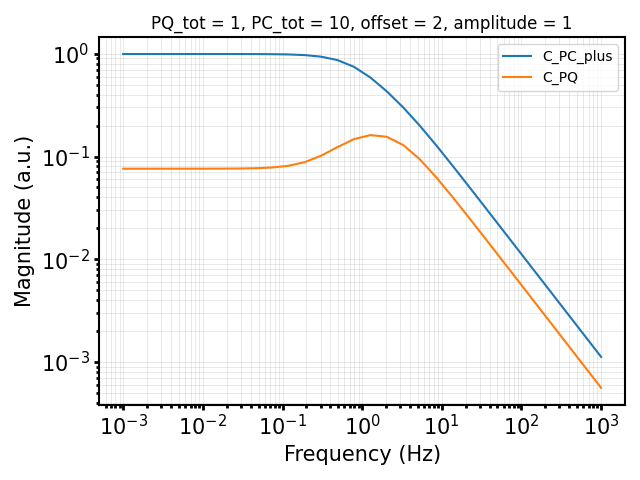

In [31]:
fig, ax = plt.subplots()
ax.plot(bode_PC_object.harmonics[f"f_input"], bode_PC_object.harmonics[f"A_0"], label = 'C_PC_plus')
ax.plot(bode_PQ_object.harmonics[f"f_input"], bode_PQ_object.harmonics[f"A_0"], label = 'C_PQ')
ax = tools.bode_plot_axes(ax)
ax.set_title(f'PQ_tot = {PQ_tot}, PC_tot = {PC_tot}, offset = {offset}, amplitude = {amplitude}')
ax.legend()
fig.tight_layout()

